## Appendix 1 - Python Code and Outputs

### Data Preparation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

NOTE: extract images from zip file into train folder in the base of the current working directory of this notebook, this can be done manually or via zipfile. Example:
<pre>
import zipfile
with zipfile.ZipFile('train.zip','r') as z:
    z.extractall("train")
    print('The train dataset is extracted into the train folder of the current working directory')
</pre>

### Import Extracted Training Data

In [2]:
import os
# import extracted training files, in this case files were extracted to the train folder in my current working directory
Train_Path = "train"
train_files = os.listdir(Train_Path)

In [3]:
# number of training images
len(train_files)

# first ten image file names
train_files[0:10]

25000

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

<Axes: >

<Axes: >

<Axes: >

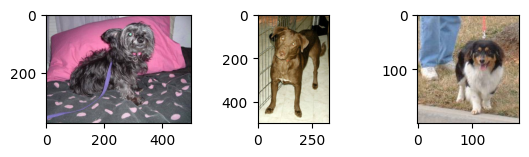

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# define location of dataset
folder = 'train/'

# plot first few images
for i in range(3):
    plt.subplot(330 + 1 + i) # define subplot
    filename = folder + 'dog.' + str(i) + '.jpg' # define filename
    image = imread(filename) # load image pixels
    plt.imshow(image) # plot raw pixel data

plt.show() # show the figure

<Axes: >

<Axes: >

<Axes: >

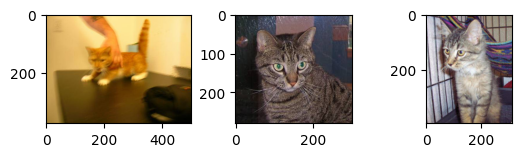

In [9]:
# plot first few images
for i in range(3):
    plt.subplot(330 + 1 + i) # define subplot
    filename = folder + 'cat.' + str(i) + '.jpg' # define filename
    image = imread(filename) # load image pixels
    plt.imshow(image) # plot raw pixel data

plt.show() # show the figure

### Extract Labels from File Names

In [10]:
# extract label from file name
label = []
identifier = []
for file in train_files:
    file_name = file.split(".")
    label.append(file_name[0])
    identifier.append(file_name[1])

# create df with id and label
train_df = pd.DataFrame(data={'id':identifier,'label':label})

# dummy encode label column
train_df["label_num"] = np.where(train_df["label"] == 'cat', 1, 0)

# number of labels should be 25000
train_df.shape

# first ten rows
train_df.head(10)

(25000, 3)

,id,label,label_num
0,0,cat,1
1,1,cat,1
2,10,cat,1
3,100,cat,1
4,1000,cat,1
5,10000,cat,1
6,10001,cat,1
7,10002,cat,1
8,10003,cat,1
9,10004,cat,1


### Plot label counts

[Text(0.5, 1.0, 'Cats and Dogs')]

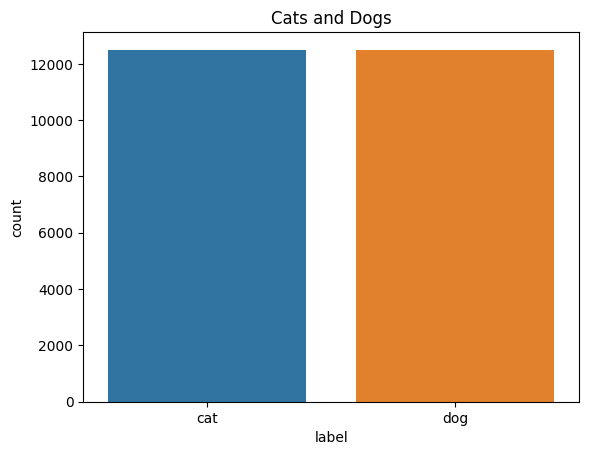

In [15]:
import seaborn as sns
import plotly as plt
sns.countplot(x=train_df.label).set(title = 'Cats and Dogs')

### Extract Image Dimensions from First 200 Training Images

In [20]:
import pandas as pd
import cv2

# loop through training files to get image dimensions
img=[]
for file in train_files[0:200]:
    count=+1
    img.append(cv2.imread(os.path.join(Train_Path,file)).shape)

# create df with dim
dim_df = pd.DataFrame(data={'dimension':img})
dim_df.head(10)

,dimension
0,"(374, 500, 3)"
1,"(280, 300, 3)"
2,"(499, 489, 3)"
3,"(499, 403, 3)"
4,"(149, 150, 3)"
5,"(359, 431, 3)"
6,"(374, 500, 3)"
7,"(471, 499, 3)"
8,"(375, 499, 3)"
9,"(239, 320, 3)"


### Import Extracted Testing Data

In [21]:
# import extracted testing files, in this case files were extracted to the test folder in my current working directory
Test_Path = "test"
test_files = os.listdir(Test_Path)

In [22]:
# number of test images
len(test_files)

# first ten image file names
test_files[0:10]

12500

['1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '10000.jpg',
 '10001.jpg',
 '10002.jpg',
 '10003.jpg',
 '10004.jpg',
 '10005.jpg']

### Crop and Resize Training Images to 150x150

In [23]:
import os
from PIL import Image

# make new directory for cropped pictures
Train_Cropped_Path = "train_cropped/"
os.mkdir(Train_Cropped_Path)

# crop images and save in train_cropped folder
for file in train_files:
    im = Image.open(os.path.join(Train_Path,file))
    im = im.resize((150, 150))
    im = im.save(f"{Train_Cropped_Path}crop{file}")

#### Move cropped images to 'cat' or 'dog' folder based on label for the image data generator

In [24]:
import shutil, sys

# image labels
categories = ['cat' , 'dog']

# function to move cat images and dog images to folders
def move_images_to_specific_folder(new_path, category):
    for image_name in os.listdir(new_path):
        if category in image_name:
            if image_name.endswith('.jpg'):
                shutil.move(os.path.join(new_path,image_name), os.path.join(new_path, category))
    
# create folders for cats and dogs
for category in categories:
    path = os.path.join(Train_Cropped_Path, category)
    os.mkdir(path)
    
# move cropped files to appropriate folder based on label
for category in categories:
    move_images_to_specific_folder(Train_Cropped_Path, category)

### Check Dimensions of Cropped Training Images

In [25]:
import shutil, sys

# loop through training files to get image dimensions
Train_Cropped_Path = "train_cropped/"

# image labels
categories = ['cat' , 'dog']

img=[]
for category in categories:
    path = os.path.join(Train_Cropped_Path, category)
    train_cropped_files = os.listdir(path)
    for file in train_cropped_files[0:10]:
        img.append(cv2.imread(os.path.join(path,file)).shape)

# create df with dimensions, all images should be 150x150
dim_cropped_df = pd.DataFrame(data={'dimension':img})
dim_cropped_df.head(10)

,dimension
0,"(150, 150, 3)"
1,"(150, 150, 3)"
2,"(150, 150, 3)"
3,"(150, 150, 3)"
4,"(150, 150, 3)"
5,"(150, 150, 3)"
6,"(150, 150, 3)"
7,"(150, 150, 3)"
8,"(150, 150, 3)"
9,"(150, 150, 3)"


The images are resized to 150x150

In [26]:
# load all libraries needed
import shutil, sys
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

### Use ImageDataGenerator to Prepare Training and Validation Batches

In [27]:
# create ImageDataGenerator to apply preprocessing for images and split data to batches
image_size = 150 # dimension of cropped image is 150x150
batch_size = 32 # start with relatively small batch size
epochs = 20 # start with 20 epochs

train_datagen = ImageDataGenerator(rescale = 1./255, # rescale the image pixels
                                   rotation_range=20,
                                   validation_split=0.2, # allocate 20% of the data as validation
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2
                                  )

train_generator = train_datagen.flow_from_directory('train_cropped', 
                                                    class_mode='binary', 
                                                    batch_size = batch_size, 
                                                    target_size=(image_size,image_size), 
                                                    subset='training', 
                                                    shuffle=True, 
                                                    seed=10)
validation_generator = train_datagen.flow_from_directory('train_cropped', 
                                                         class_mode='binary', 
                                                         batch_size = batch_size, 
                                                         target_size=(image_size,image_size), 
                                                         subset='validation', 
                                                         shuffle=True, 
                                                         seed=10)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


STILL WORKING ON ADJUSTING MODEL PARAMETERS - WORK IN PROGRESS

In [14]:
# Build Initial Sequential Model
model = Sequential()
# 2D convolutional layer w/64 filters, 5x5 kernel, and ReLU activation function. Model expects 150x150 image with 3 channels.
model.add(Conv2D(input_shape=(150,150,3), filters = 64, kernel_size=(5,5), activation="relu"))
# max pooling layer
model.add(MaxPool2D(pool_size=(2,2)))

# Conv2D and MaxPooling2D layers with 32 filters and 3x3 kernel.
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv2D and MaxPooling2D layers with 16 filters 3x3 kernel.
model.add(Conv2D(filters = 16, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# add dropout to avoid overfitting
model.add(Dropout(0.25))

# flatten output of the previous layer - converts to 1d layer
model.add(Flatten())

# add dense layer
model.add(Dense(32, activation='relu'))

# add dropout to avoid overfitting
model.add(Dropout(0.5))

# add dense layer
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

2023-05-19 16:15:07.971787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 16:15:08.082920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 16:15:08.082983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 16:15:08.087324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 16:15:08.087388: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [15]:
# Adam solver optimizer with learning rate of 0.001
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

# compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
import warnings
warnings.filterwarnings('ignore')
# early stopping based on validation loss (stops if model doesn't improve after 5 iterations)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# save the best model as 'best_model.cnn' based on validation loss
save_best = ModelCheckpoint(filepath = 'best_model.cnn', verbose=1, save_best_only=True)

# fit model using batches of training data and batches of testing data
history = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, 
                              epochs = epochs, 
                              callbacks=[save_best, early_stopping], 
                              verbose=2)

Epoch 1/20


2023-05-19 16:15:47.299673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-19 16:15:47.875890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 16:15:53.695685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-19 16:16:02.147826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 16:16:02.213183: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x33f7e8d0 initia


Epoch 1: val_loss improved from inf to 0.68270, saving model to best_model.cnn


2023-05-19 16:20:46.868148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:20:46.883213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:20:47.116625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 301s - loss: 0.6890 - accuracy: 0.5386 - val_loss: 0.6827 - val_accuracy: 0.5721 - 301s/epoch - 481ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.68270 to 0.65307, saving model to best_model.cnn


2023-05-19 16:25:14.614783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:25:14.630243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:25:15.519815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 268s - loss: 0.6728 - accuracy: 0.5864 - val_loss: 0.6531 - val_accuracy: 0.6178 - 268s/epoch - 429ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.65307 to 0.62187, saving model to best_model.cnn


2023-05-19 16:29:37.320760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:29:37.336567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:29:37.492521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 262s - loss: 0.6527 - accuracy: 0.6202 - val_loss: 0.6219 - val_accuracy: 0.6518 - 262s/epoch - 419ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.62187 to 0.59946, saving model to best_model.cnn


2023-05-19 16:34:03.087456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:34:03.098684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:34:03.252837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 266s - loss: 0.6289 - accuracy: 0.6510 - val_loss: 0.5995 - val_accuracy: 0.6865 - 266s/epoch - 425ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.59946 to 0.57827, saving model to best_model.cnn


2023-05-19 16:38:18.224869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:38:18.238906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:38:18.399162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 255s - loss: 0.6102 - accuracy: 0.6727 - val_loss: 0.5783 - val_accuracy: 0.6991 - 255s/epoch - 408ms/step
Epoch 6/20

Epoch 6: val_loss did not improve from 0.57827
625/625 - 259s - loss: 0.5978 - accuracy: 0.6837 - val_loss: 0.5888 - val_accuracy: 0.6845 - 259s/epoch - 415ms/step
Epoch 7/20

Epoch 7: val_loss improved from 0.57827 to 0.55521, saving model to best_model.cnn


2023-05-19 16:47:03.679394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:47:03.697301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:47:04.141093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 266s - loss: 0.5871 - accuracy: 0.6973 - val_loss: 0.5552 - val_accuracy: 0.7198 - 266s/epoch - 426ms/step
Epoch 8/20

Epoch 8: val_loss improved from 0.55521 to 0.53402, saving model to best_model.cnn


2023-05-19 16:51:40.930446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:51:40.944853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:51:41.092140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 277s - loss: 0.5693 - accuracy: 0.7096 - val_loss: 0.5340 - val_accuracy: 0.7398 - 277s/epoch - 443ms/step
Epoch 9/20

Epoch 9: val_loss improved from 0.53402 to 0.51636, saving model to best_model.cnn


2023-05-19 16:56:12.736299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 16:56:12.749123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 16:56:12.901291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 272s - loss: 0.5559 - accuracy: 0.7260 - val_loss: 0.5164 - val_accuracy: 0.7516 - 272s/epoch - 435ms/step
Epoch 10/20

Epoch 10: val_loss did not improve from 0.51636
625/625 - 259s - loss: 0.5477 - accuracy: 0.7303 - val_loss: 0.5186 - val_accuracy: 0.7526 - 259s/epoch - 415ms/step
Epoch 11/20

Epoch 11: val_loss improved from 0.51636 to 0.50657, saving model to best_model.cnn


2023-05-19 17:04:58.936418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:04:58.949972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:04:59.095736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 267s - loss: 0.5379 - accuracy: 0.7388 - val_loss: 0.5066 - val_accuracy: 0.7562 - 267s/epoch - 427ms/step
Epoch 12/20

Epoch 12: val_loss improved from 0.50657 to 0.50519, saving model to best_model.cnn


2023-05-19 17:09:25.772791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:09:25.788787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:09:26.198490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 267s - loss: 0.5334 - accuracy: 0.7412 - val_loss: 0.5052 - val_accuracy: 0.7656 - 267s/epoch - 427ms/step
Epoch 13/20

Epoch 13: val_loss improved from 0.50519 to 0.49208, saving model to best_model.cnn


2023-05-19 17:13:54.312360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:13:54.329135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:13:54.479357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 268s - loss: 0.5290 - accuracy: 0.7436 - val_loss: 0.4921 - val_accuracy: 0.7714 - 268s/epoch - 429ms/step
Epoch 14/20

Epoch 14: val_loss improved from 0.49208 to 0.48775, saving model to best_model.cnn


2023-05-19 17:18:18.912751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:18:18.926411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:18:19.076868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 265s - loss: 0.5205 - accuracy: 0.7480 - val_loss: 0.4877 - val_accuracy: 0.7754 - 265s/epoch - 423ms/step
Epoch 15/20

Epoch 15: val_loss improved from 0.48775 to 0.47903, saving model to best_model.cnn


2023-05-19 17:22:38.752108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:22:38.763135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:22:38.923388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 260s - loss: 0.5115 - accuracy: 0.7560 - val_loss: 0.4790 - val_accuracy: 0.7752 - 260s/epoch - 416ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 0.47903
625/625 - 264s - loss: 0.5049 - accuracy: 0.7606 - val_loss: 0.4937 - val_accuracy: 0.7636 - 264s/epoch - 423ms/step
Epoch 17/20

Epoch 17: val_loss did not improve from 0.47903
625/625 - 261s - loss: 0.5063 - accuracy: 0.7581 - val_loss: 0.4855 - val_accuracy: 0.7841 - 261s/epoch - 417ms/step
Epoch 18/20

Epoch 18: val_loss did not improve from 0.47903
625/625 - 270s - loss: 0.4957 - accuracy: 0.7634 - val_loss: 0.4937 - val_accuracy: 0.7652 - 270s/epoch - 432ms/step
Epoch 19/20

Epoch 19: val_loss improved from 0.47903 to 0.46612, saving model to best_model.cnn


2023-05-19 17:40:34.776138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:40:34.790559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:40:34.939172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 281s - loss: 0.4909 - accuracy: 0.7691 - val_loss: 0.4661 - val_accuracy: 0.7889 - 281s/epoch - 449ms/step
Epoch 20/20

Epoch 20: val_loss improved from 0.46612 to 0.46608, saving model to best_model.cnn


2023-05-19 17:44:58.717570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05-19 17:44:58.734800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-19 17:44:58.883279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,16,16]
	 [[{{node inputs}}]]
2023-05

INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


625/625 - 264s - loss: 0.4922 - accuracy: 0.7710 - val_loss: 0.4661 - val_accuracy: 0.7883 - 264s/epoch - 422ms/step


In [17]:
# show best model
best_model = tf.keras.models.load_model('best_model.cnn')
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

### Loss Charts

[None, None, None]

[None, None, None]

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

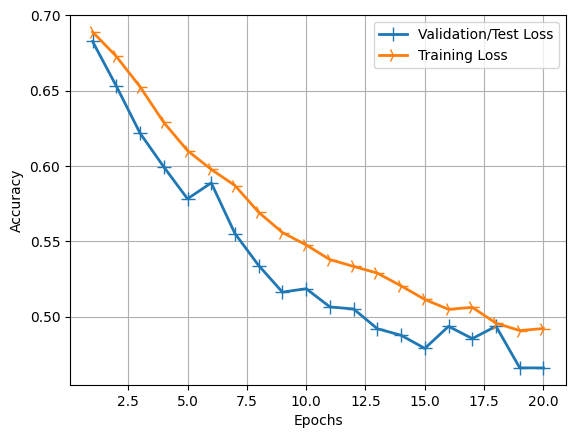

In [18]:
history_dict = history.history

# extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# save epochs
epochs = range(1, len(loss_values)+1)

# plot loss
line1 = plt.plot(epochs, val_loss_values, label ='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.setp(line1, linewidth = 2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# set labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

### Accuracy Charts

[None, None, None]

[None, None, None]

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

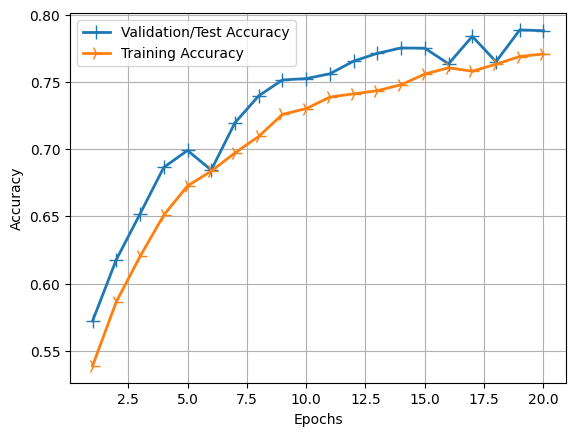

In [19]:
# extract acuuracy scores
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

#plot accuracy scores
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label ='Training Accuracy')

plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# set labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.grid(True)
plt.legend()
plt.show()

### Crop and Resize Testing Images to 150x150

In [28]:
# make new directory for cropped images
Test_Cropped_Path = "test_cropped/"
os.mkdir(Test_Cropped_Path)

# crop images and save in train_cropped folder
for file in test_files:
    im = Image.open(os.path.join(Test_Path,file))
    im = im.resize((150, 150))
    im = im.save(f"{Test_Cropped_Path}{file}")

test_cropped_files = os.listdir(Test_Cropped_Path)
# create dataframe with filenames
test_df = pd.DataFrame(data = test_cropped_files, columns = ['filename'])
# extract id from filename
test_df['id'] = test_df['filename'].apply(lambda f: int(f.split('.')[0]))
test_df.sort_values(by = 'id', inplace = True, ignore_index = True)
# show first 5 rows of df
test_df.head()

,filename,id
0,1.jpg,1
1,2.jpg,2
2,3.jpg,3
3,4.jpg,4
4,5.jpg,5


### Input Test Data into Testing Generator for Model Predictions

In [22]:
# rescale image pixels
test_gen = ImageDataGenerator(rescale = 1./255)
# create test generator for testing data
test_generator = test_gen.flow_from_dataframe(test_df, 
                                               directory='test_cropped', 
                                               x_col='filename',
                                               class_mode= None,
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               shuffle=False
)

Found 710 validated image filenames.


### Save Predictions into CSV file for Kaggle

In [23]:
# Apply the cnn model1 to the test dataset
cnn_pred1 = best_model.predict(test_generator, verbose = 1)

# Put the label predictions into a dataframe
cnn_pred1_df = pd.DataFrame(cnn_pred1, columns=['label'])

# Add the ID column to the front of the cnn predictions dataframe
cnn_pred1_df.insert(0, 'id', test_df['id'])

# Output predictions to csv
#cnn_pred1_df.to_csv('test_predictions_cnn_v3.csv', index=False)

2023-05-19 18:45:15.508063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


391/391 [==============================] - 76s 194ms/step


Let's display the Kaggle results from the application of the CNN model on the test dataset

<Figure size 1500x1500 with 0 Axes>

(-0.5, 1222.5, 481.5, -0.5)

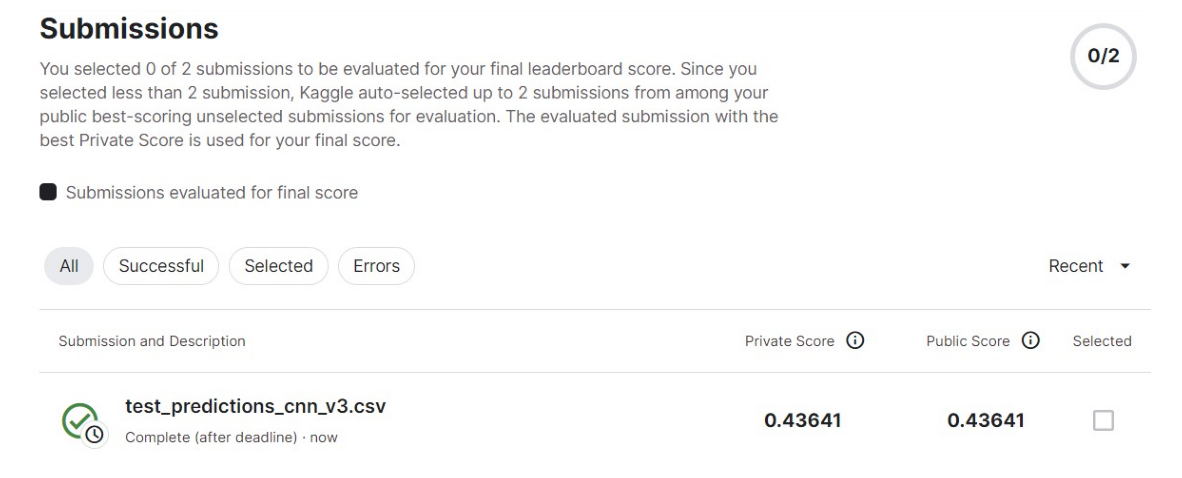

In [25]:
# Display the kaggle results (log loss) of CNN model
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
kaggle_results = plt.imread('Kaggle_results_cnn_v3.jpg')
plt.imshow(kaggle_results)
plt.axis("off")
plt.show()

# CNN Model 2

#### Manny's section

In [ ]:
# Build Initial Sequential Model
model = Sequential()

# One 2D convolutional layer w/64 filters, 7x7 kernel, and ReLu activation function. Model expects 150x150 image with 3 channels.
model.add(Conv2D(input_shape=(150,150,3), filters = 64, kernel_size=(7,7), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2))) #max pooling layer that divides spatial dimensions by a factor of 2

# Two 2D convolutional layer w/128 filters, 3x3 kernel, and ReLu activation function. Model expects 150x150 image with 3 channels.
model.add(Conv2D(input_shape=(150,150,3), filters = 128, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(input_shape=(150,150,3), filters = 128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2))) #max pooling layer that divides spatial dimensions by a factor of 2

# Two 2D convolutional layer w/128 filters, 3x3 kernel, and ReLu activation function. Model expects 150x150 image with 3 channels.
model.add(Conv2D(input_shape=(150,150,3), filters = 256, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(input_shape=(150,150,3), filters = 256, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2))) #max pooling layer that divides spatial dimensions by a factor of 2

# Flatten layers because the model expects a 1D array
model.add(Flatten())

# Add two sets of layers (one dense layer and one dropout layer) to reduce overfitting, dropout set to 50%
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))

# Add final softmax 
model.add(Dense(units=10, activation ='softmax'))

model.summary()

## CNN Model 3

In [29]:
# Build Initial Sequential Model
model = Sequential()
# 2D convolutional layer w/64 filters, 5x5 kernel, and ReLU activation function. Model expects 150x150 image with 3 channels.
model.add(Conv2D(input_shape=(150,150,3), filters = 64, kernel_size=(3,3), activation="relu"))
# max pooling layer
model.add(MaxPool2D(pool_size=(2,2)))

# Conv2D and MaxPooling2D layers with 32 filters and 3x3 kernel.
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv2D and MaxPooling2D layers with 16 filters 3x3 kernel.
model.add(Conv2D(filters = 16, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# Conv2D and MaxPooling2D layers with 8 filters 3x3 kernel.
model.add(Conv2D(filters = 8, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

# add dropout to avoid overfitting
model.add(Dropout(0.25))

# flatten output of the previous layer - converts to 1d layer
model.add(Flatten())

# add dense layer
model.add(Dense(32, activation='relu'))

# add dropout to avoid overfitting
model.add(Dropout(0.5))

# add dense layer
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 16)       0

In [30]:
# Adam solver optimizer with learning rate of 0.001
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

# compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [31]:
import warnings
warnings.filterwarnings('ignore')
# early stopping based on validation loss (stops if model doesn't improve after 5 iterations)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# save the best model as 'best_model.cnn' based on validation loss
save_best = ModelCheckpoint(filepath = 'best_model.cnn', verbose=1, save_best_only=True)

# fit model using batches of training data and batches of testing data
history = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, 
                              epochs = epochs, 
                              callbacks=[save_best, early_stopping], 
                              verbose=2)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.69313, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 277s - loss: 0.6923 - accuracy: 0.5064 - val_loss: 0.6931 - val_accuracy: 0.5012 - 277s/epoch - 443ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.69313 to 0.68328, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 434s - loss: 0.6880 - accuracy: 0.5398 - val_loss: 0.6833 - val_accuracy: 0.5625 - 434s/epoch - 695ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.68328 to 0.68228, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 273s - loss: 0.6850 - accuracy: 0.5567 - val_loss: 0.6823 - val_accuracy: 0.5661 - 273s/epoch - 437ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.68228 to 0.63928, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 286s - loss: 0.6667 - accuracy: 0.5981 - val_loss: 0.6393 - val_accuracy: 0.6440 - 286s/epoch - 458ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.63928 to 0.59710, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 296s - loss: 0.6311 - accuracy: 0.6524 - val_loss: 0.5971 - val_accuracy: 0.6791 - 296s/epoch - 474ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.59710 to 0.57603, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 283s - loss: 0.6116 - accuracy: 0.6726 - val_loss: 0.5760 - val_accuracy: 0.7061 - 283s/epoch - 452ms/step
Epoch 7/20

Epoch 7: val_loss improved from 0.57603 to 0.57186, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 267s - loss: 0.5896 - accuracy: 0.6934 - val_loss: 0.5719 - val_accuracy: 0.7049 - 267s/epoch - 427ms/step
Epoch 8/20

Epoch 8: val_loss improved from 0.57186 to 0.53828, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 263s - loss: 0.5726 - accuracy: 0.7097 - val_loss: 0.5383 - val_accuracy: 0.7264 - 263s/epoch - 421ms/step
Epoch 9/20

Epoch 9: val_loss improved from 0.53828 to 0.52228, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 267s - loss: 0.5487 - accuracy: 0.7308 - val_loss: 0.5223 - val_accuracy: 0.7392 - 267s/epoch - 427ms/step
Epoch 10/20

Epoch 10: val_loss improved from 0.52228 to 0.51092, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 271s - loss: 0.5340 - accuracy: 0.7427 - val_loss: 0.5109 - val_accuracy: 0.7508 - 271s/epoch - 433ms/step
Epoch 11/20

Epoch 11: val_loss did not improve from 0.51092
625/625 - 261s - loss: 0.5187 - accuracy: 0.7508 - val_loss: 0.5174 - val_accuracy: 0.7488 - 261s/epoch - 417ms/step
Epoch 12/20

Epoch 12: val_loss improved from 0.51092 to 0.46864, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 272s - loss: 0.5053 - accuracy: 0.7595 - val_loss: 0.4686 - val_accuracy: 0.7788 - 272s/epoch - 435ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 0.46864
625/625 - 272s - loss: 0.4950 - accuracy: 0.7695 - val_loss: 0.4850 - val_accuracy: 0.7760 - 272s/epoch - 436ms/step
Epoch 14/20

Epoch 14: val_loss improved from 0.46864 to 0.46247, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 256s - loss: 0.4837 - accuracy: 0.7753 - val_loss: 0.4625 - val_accuracy: 0.7867 - 256s/epoch - 409ms/step
Epoch 15/20

Epoch 15: val_loss improved from 0.46247 to 0.44977, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 278s - loss: 0.4713 - accuracy: 0.7849 - val_loss: 0.4498 - val_accuracy: 0.7997 - 278s/epoch - 444ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 0.44977
625/625 - 266s - loss: 0.4630 - accuracy: 0.7887 - val_loss: 0.4639 - val_accuracy: 0.7865 - 266s/epoch - 425ms/step
Epoch 17/20

Epoch 17: val_loss improved from 0.44977 to 0.42808, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 271s - loss: 0.4620 - accuracy: 0.7890 - val_loss: 0.4281 - val_accuracy: 0.8127 - 271s/epoch - 434ms/step
Epoch 18/20

Epoch 18: val_loss improved from 0.42808 to 0.41266, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 271s - loss: 0.4526 - accuracy: 0.7953 - val_loss: 0.4127 - val_accuracy: 0.8197 - 271s/epoch - 433ms/step
Epoch 19/20

Epoch 19: val_loss improved from 0.41266 to 0.40451, saving model to best_model.cnn


INFO:tensorflow:Assets written to: best_model.cnn\assets


INFO:tensorflow:Assets written to: best_model.cnn\assets


625/625 - 259s - loss: 0.4451 - accuracy: 0.7996 - val_loss: 0.4045 - val_accuracy: 0.8249 - 259s/epoch - 415ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 0.40451
625/625 - 273s - loss: 0.4355 - accuracy: 0.8052 - val_loss: 0.4314 - val_accuracy: 0.8039 - 273s/epoch - 437ms/step


In [32]:
# show best model
best_model = tf.keras.models.load_model('best_model.cnn')
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 16)       0

#### Loss Charts

In [33]:
history_dict = history.history

# extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# save epochs
epochs = range(1, len(loss_values)+1)

# plot loss
line1 = plt.plot(epochs, val_loss_values, label ='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.setp(line1, linewidth = 2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# set labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

NotImplementedError: kind='[0.6931345462799072, 0.68327796459198, 0.682282567024231, 0.6392815709114075, 0.5970985293388367, 0.576031506061554, 0.5718643069267273, 0.5382824540138245, 0.5222784876823425, 0.5109174847602844, 0.5174452662467957, 0.4686395227909088, 0.48496168851852417, 0.4624677896499634, 0.4497663676738739, 0.46393564343452454, 0.4280783236026764, 0.412659227848053, 0.4045089781284332, 0.4314437210559845]' not yet supported for plotting.backend='plotly'

#### Accuracy Charts

In [34]:
# extract acuuracy scores
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

#plot accuracy scores
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label ='Training Accuracy')

plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# set labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.grid(True)
plt.legend()
plt.show()

NotImplementedError: kind='[0.5012019276618958, 0.5625, 0.5661057829856873, 0.6440304517745972, 0.6790865659713745, 0.706129789352417, 0.7049278616905212, 0.7263621687889099, 0.739182710647583, 0.7508012652397156, 0.7487980723381042, 0.7788461446762085, 0.7760416865348816, 0.7866586446762085, 0.7996794581413269, 0.7864583134651184, 0.8127003312110901, 0.8197115659713745, 0.8249198794364929, 0.8038862347602844]' not yet supported for plotting.backend='plotly'

#### Input Testing Data into Testing Generator for Model Predictions

In [35]:
# rescale image pixels
test_gen = ImageDataGenerator(rescale = 1./255)
# create test generator for testing data
test_generator = test_gen.flow_from_dataframe(test_df, 
                                               directory='test_cropped', 
                                               x_col='filename',
                                               class_mode= None,
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               shuffle=False
)

Found 12500 validated image filenames.


#### Save Predictions into CSV for Kaggle

In [36]:
# Apply the cnn model1 to the test dataset
cnn_pred3 = best_model.predict(test_generator, verbose = 1)

# Put the label predictions into a dataframe
cnn_pred3_df = pd.DataFrame(cnn_pred3, columns=['label'])

# Add the ID column to the front of the cnn predictions dataframe
cnn_pred3_df.insert(0, 'id', test_df['id'])

# Output predictions to csv
cnn_pred3_df.to_csv('test_predictions_cnn_v3.csv', index=False)

391/391 [==============================] - 40s 102ms/step


#### Display the Kaggle results from the application of the CNN model on the test dataset

<Figure size 1500x1500 with 0 Axes>

(-0.5, 1488.5, 513.5, -0.5)

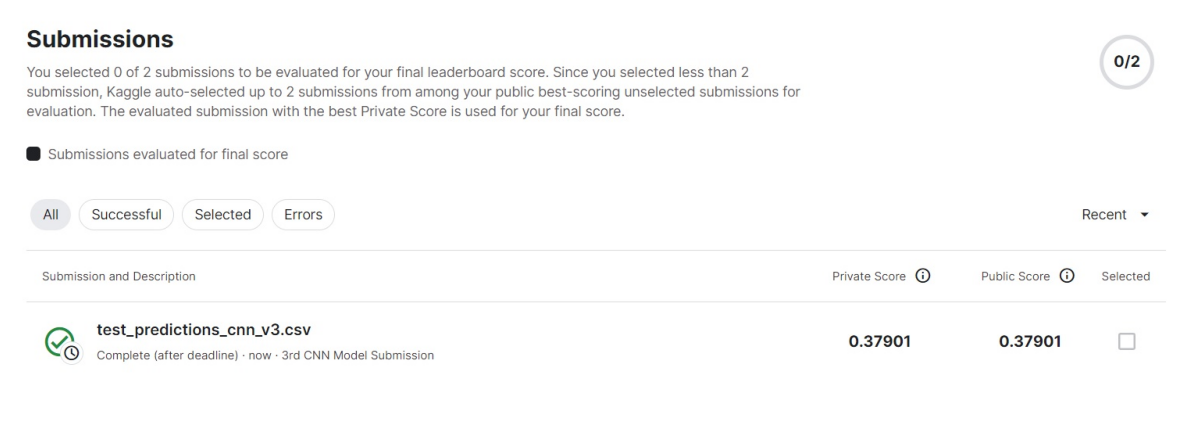

In [38]:
# Display the kaggle results (log loss) of CNN model
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
kaggle_results = plt.imread('Kaggle_results_cnn_v3.jpg')
plt.imshow(kaggle_results)
plt.axis("off")
plt.show()